# NBA Result Prediction
## Toliopoulou Christianna 
### MSc in Artificial Intelligence- Machine Learning Course

Purpose of this project is to predict the result of NBA games. In order to do so we will extract data then perform pre-processing and feature selection and finally run an SVM and Decision tree model 

# Background

Data are retrieved from nba_api to retrieve statistics regarding games.It is an API Client for www.nba.com. This package is meant to make the API Endpoints more accessible and to provide extensive documentation. There is also a public Slack channel that has been setup for people to chat and receive help

# Libraries

In [105]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [156]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats import endpoints
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import teaminfocommon
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import franchiseplayers
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamhistoricalleaders
from nba_api.stats.static import teams 
from datetime import datetime as dt
import pandas as pd 
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool
from bokeh.io import show, output_notebook
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
import itertools
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

from pprint import pprint
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Retrieve statistics

In [107]:
# import dataframe from league game finder endpoint
all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# Initial data exploration

We perform an initial data exploration in order to understand our data. As we may see there are some null values which will be removed in order for our data to be clean. Most of these NA represent fantasy games (2K).

In [108]:
all_games.info()
all_games.isnull().sum()

#remove null values

all_games2 = all_games.dropna(how='any') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          30000 non-null  object 
 1   TEAM_ID            30000 non-null  int64  
 2   TEAM_ABBREVIATION  30000 non-null  object 
 3   TEAM_NAME          30000 non-null  object 
 4   GAME_ID            30000 non-null  object 
 5   GAME_DATE          30000 non-null  object 
 6   MATCHUP            30000 non-null  object 
 7   WL                 29985 non-null  object 
 8   MIN                30000 non-null  int64  
 9   PTS                30000 non-null  int64  
 10  FGM                30000 non-null  int64  
 11  FGA                30000 non-null  int64  
 12  FG_PCT             29998 non-null  float64
 13  FG3M               30000 non-null  int64  
 14  FG3A               30000 non-null  int64  
 15  FG3_PCT            29995 non-null  float64
 16  FTM                300

Our dataset includes WNBA, All Star games, G League games,  which are not in the scope of this study. Since we will analyze only men NBA games these data should be removed

In [109]:
#extract unique teams from our dataset

unique_teams = all_games2.TEAM_NAME.unique()
uniqueValues = len(unique_teams)
print('Unique Teams of initial dataset : ', uniqueValues)

unique_seasons = all_games2.SEASON_ID.unique()
uniqueValues2 = len(unique_seasons)
print('Unique seasons of initial dataset : ', uniqueValues2)

# NBA men teams which should be included in the end
teams = teams.get_teams()

# convert teams json table to dataframe

teams_df =  pd.DataFrame.from_dict(pd.json_normalize(teams), orient='columns')

uniqueValues3 = len(teams_df)
print('Unique Teams of final dataset : ', uniqueValues3)

Unique Teams of initial dataset :  239
Unique seasons of initial dataset :  34
Unique Teams of final dataset :  30


In [110]:
#rename id column to TEAM_ID in order to merge later with our initial data 

teams_df = teams_df.rename(columns={'id': 'TEAM_ID',})

opponent_df = teams_df.rename(columns={'TEAM_ID': 'OPP_ID',})
opponent_df = opponent_df.rename(columns={'abbreviation': 'OPPONENT',})
opponent_df = opponent_df[['OPP_ID', 'OPPONENT']]

In [111]:
#We drop WNBA, ALL star games etc as we will focus only on regular season and playoff matches. This means that the null values which derive after merging represent not needed matchups

merged_d1 = pd.merge(all_games, teams_df, on='TEAM_ID', how='left')
merged_d2 = merged_d1.dropna(how='any') 
null_data = merged_d2[merged_d1.isnull().any(axis=1)]
unique_teams = merged_d2.TEAM_ID.unique()
uniqueValues3 = len(unique_teams)
print('Unique Teams of processed dataset : ', uniqueValues3)


Unique Teams of processed dataset :  30


In [112]:
#drop some column names as they are exactly the same

merged_d2 = merged_d2.drop(['full_name','abbreviation'], 1)

# Feature Engineering

In this section we will create some extra variables which may help in the prediction of the winner. These will be divided into static variables (is_home) as well as time dependent. The reason I created time dependent variables is in order to incorporate time dimension without explicilty using date in modeling. 

In [113]:
###STATIC FEATURES 

# is home variable - defines if the team plays home or away

merged_d2.loc[merged_d2['MATCHUP'].str.contains('@'), 'is_home'] = 0
merged_d2['is_home'] = merged_d2['is_home'].fillna(1)

# define opposing team and id

merged_d2['OPPONENT'] = merged_d2['MATCHUP'].str[-3:]
merged_d2 = pd.merge(merged_d2, opponent_df, on='OPPONENT', how='left')
check = merged_d2.OPP_ID.unique()
merged_d2 = merged_d2.dropna(how='any') 
merged_d2['OPP_ID'] = merged_d2['OPP_ID'].astype(np.int64)
check = merged_d2.OPP_ID.unique()

# define Win or Loss

merged_d2.loc[merged_d2['WL'].str.contains('W'), 'Win_Loss'] = 1
merged_d2.loc[merged_d2['WL'].str.contains('L'), 'Win_Loss'] = 0

In [114]:
###TIME DEPENDENT FEATURES


def add_variable_features(merged_d2, N=11):
    """ Given a dataframe league_df, returns a new df containing extra columns for each new feature.
        If new_years = true, adds features that only work for data frames containing data >= 2005
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        N (int): lookback parameter
    Output:
        pd.DataFrame with added variables: 
        4. home_win_pct (win percentage of the home team prior to the current game)
        5. away_win_pct (win percentage of the away team prior to the current game)
        6. home_avg_pt_diff (average pt differential of the home team prior to the current game)
        7. away_avg_pt_diff (average pt differential of the away team prior to the current game)
        8. home_win_pct_N (win percentage of the home team in last N games prior to the current game)
        9. away_win_pct_N (win percentage of the away team in last N games prior to the current game)
        10. home_win_pct_as_home (win percentage of the home team as home prior to the current game)
        11. away_win_pct_as_away (win percentage of the away team as away prior to the current game)
        12. home_back_to_back (1 if the home team just played the day prior, 0 otherwise)
        13. away_back_to_back (1 if the away team just played the day prior, 0 otherwise)
        14. home_game_count (# games the home team as played prior to the current game)
        15. away_game_count (# games the away team as played prior to the current game)
    """    
    lookback = N
    new_df = merged_d2.sort_values('GAME_DATE')
    
    # Add new columns
    home_win_pct = np.zeros(len(new_df))
    away_win_pct = np.zeros(len(new_df))
    home_avg_pt_diff = np.zeros(len(new_df))
    away_avg_pt_diff = np.zeros(len(new_df))
    home_win_pct_N = np.zeros(len(new_df))
    away_win_pct_N = np.zeros(len(new_df))
    away_win_pct_as_away = np.zeros(len(new_df))
    home_win_pct_as_home = np.zeros(len(new_df))
    home_back_to_back = np.zeros(len(new_df))
    away_back_to_back = np.zeros(len(new_df))
    home_game_count = np.zeros(len(new_df))
    away_game_count = np.zeros(len(new_df))
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_win_pct = home_win_pct)
    new_df = new_df.assign(away_win_pct = away_win_pct)
    new_df = new_df.assign(home_avg_pt_diff = home_avg_pt_diff)
    new_df = new_df.assign(away_avg_pt_diff = away_avg_pt_diff)
    new_df = new_df.assign(home_win_pct_N = home_win_pct_N)
    new_df = new_df.assign(away_win_pct_N = away_win_pct_N)
    new_df = new_df.assign(away_win_pct_as_away = away_win_pct_as_away)
    new_df = new_df.assign(home_win_pct_as_home = home_win_pct_as_home)
    new_df = new_df.assign(home_back_to_back = home_back_to_back)
    new_df = new_df.assign(away_back_to_back = away_back_to_back)
    new_df = new_df.assign(home_game_count = home_game_count)
    new_df = new_df.assign(away_game_count = away_game_count)
    
    # add features
    grouped = new_df.groupby(['SEASON_ID'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        # Initialize dictionary containing wins and losses for each team
        win_dict = dict()
        lose_dict = dict()
        running_dict = dict()
        
        # Stores list of game dates for each team
        running_date_dict = dict()
        
        # Total plus minus so far
        plus_minus_dict = dict()
        
        # Stores home and away game counts and w/l counts
        wins_as_home = dict()
        wins_as_away = dict()
        games_as_home = dict()
        games_as_away = dict()
        
        running_locations = dict()
        
        for team in season_df['TEAM_ID'].unique():
            win_dict[team] = 0
            lose_dict[team] = 0
            running_dict[team] = []
            plus_minus_dict[team] = 0
            running_date_dict[team] = []
            
            # Track wins at home, at away, and total games at home, at away
            wins_as_home[team] = 0
            wins_as_away[team] = 0
            games_as_home[team] = 0
            games_as_away[team] = 0
        
        # Sort season by day
        season_df = season_df.sort_values('GAME_DATE')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['TEAM_ID']
            opp_team_id = row['OPP_ID']
            wl = row['Win_Loss']
            game_id = row['GAME_ID']
            curr_team_plus_minus = row['PLUS_MINUS']
            opp_team_plus_minus = -curr_team_plus_minus
            game_date = row['GAME_DATE']
            game_date = dt.strptime( game_date, '%Y-%m-%d').date()
           
            season_id = row['SEASON_ID']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id
                
            # Update home_win_pct, away_win_pct
            home_win_pct = 0
            away_win_pct = 0

            if win_dict[home_team_id] + lose_dict[home_team_id] > 0:
                home_win_pct = (win_dict[home_team_id])/float(win_dict[home_team_id] + lose_dict[home_team_id])
            if win_dict[away_team_id] + lose_dict[away_team_id] > 0:
                away_win_pct = (win_dict[away_team_id])/float(win_dict[away_team_id] + lose_dict[away_team_id])
                
            new_df.at[index, 'home_win_pct']= home_win_pct
            new_df.at[index, 'away_win_pct']= away_win_pct
        
            
            # Update home_win_pct_N, away_win_pct_N
            home_win_pct_N = 0
            away_win_pct_N = 0
            
            home_games_count = len(running_dict[home_team_id])
            away_games_count = len(running_dict[away_team_id])
            
            new_df.at[index, 'home_game_count']=home_games_count
            new_df.at[index, 'away_game_count']=away_games_count
            
            if home_games_count > 0:
                if home_games_count > lookback:
                    lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                else:
                    lookback_games = running_dict[home_team_id]
                home_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            if away_games_count > 0:
                if away_games_count > lookback:
                    lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                else:
                    lookback_games = running_dict[away_team_id]
                away_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            new_df.at[index, 'home_win_pct_N']= home_win_pct_N
            new_df.at[index, 'away_win_pct_N']= away_win_pct_N
            
            # Update home_avg_pt_diff, away_avg_pt_diff
            home_avg_pt_diff = 0
            away_avg_pt_diff = 0
            
            if home_games_count > 0:
                running_pt_diff = plus_minus_dict[home_team_id]
                home_avg_pt_diff = running_pt_diff/float(home_games_count)
            if away_games_count > 0:
                running_pt_diff = plus_minus_dict[away_team_id]
                away_avg_pt_diff = running_pt_diff/float(away_games_count)
                
            new_df.at[index, 'home_avg_pt_diff']= home_avg_pt_diff
            new_df.at[index, 'away_avg_pt_diff']= away_avg_pt_diff
            
            # Update back-to-back indicators   
            home_back_to_back = 0
            away_back_to_back = 0
            
            if home_games_count > 0:
                most_recent_date = running_date_dict[home_team_id][home_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    home_back_to_back = 1
                
            if away_games_count > 0:
                most_recent_date = running_date_dict[away_team_id][away_games_count - 1]
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # Back-to-back
                    away_back_to_back = 1
                    
            new_df.at[index, 'home_back_to_back']= home_back_to_back
            new_df.at[index, 'away_back_to_back']= away_back_to_back
            
            # Update home_win_pct_as_home, away_win_pct_as_away
            home_win_pct_as_home = 0
            away_win_pct_as_away = 0
            
            home_games_as_home = games_as_home[home_team_id]
            away_games_as_away = games_as_away[away_team_id]
            
            if (home_games_as_home > 0):
                home_win_pct_as_home = (wins_as_home[home_team_id])/float(home_games_as_home)
            if (away_games_as_away > 0):
                away_win_pct_as_away = (wins_as_away[away_team_id])/float(away_games_as_away)
                
            new_df.at[index, 'home_win_pct_as_home']= home_win_pct_as_home
            new_df.at[index, 'away_win_pct_as_away']= away_win_pct_as_away 
                
            # Update running stats
            if (wl == 'W'):
                if game_id in seen_games:
                    win_dict[team_id] += 1
                    lose_dict[opp_team_id] += 1
                    running_dict[team_id].append(1)
                    running_dict[opp_team_id].append(0)
                    
                    # Update home team and away team w/l
                    if is_home == 1:
                        wins_as_home[team_id] += 1
                        games_as_home[team_id] += 1
                        games_as_away[opp_team_id] += 1
                    else:
                        wins_as_away[team_id] += 1
                        games_as_away[team_id] += 1
                        games_as_home[opp_team_id] += 1
                    
            else:
                if game_id in seen_games:
                    win_dict[opp_team_id] += 1
                    lose_dict[team_id] += 1
                    running_dict[opp_team_id].append(1)
                    running_dict[team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_away[opp_team_id] += 1
                        games_as_away[opp_team_id] += 1
                        games_as_home[team_id] += 1
                        
                    else:
                        wins_as_home[opp_team_id] += 1
                        games_as_home[opp_team_id] += 1
                        games_as_away[team_id] += 1
            if game_id in seen_games:
                plus_minus_dict[team_id] += curr_team_plus_minus
                plus_minus_dict[opp_team_id] += opp_team_plus_minus
                running_date_dict[team_id].append(game_date)
                running_date_dict[opp_team_id].append(game_date)
                
            seen_games.add(game_id)
    return new_df

all_games3= add_variable_features(merged_d2,11)

#drop out useless columns

all_games_4 = all_games3.drop(columns=['WL','TEAM_ABBREVIATION','MATCHUP','nickname','city','state','year_founded','OPPONENT','PLUS_MINUS'])


# Additional Features

## Altidute

Altidute may affect the performance of teams that are not used to high elevations. For example Denver Nuggets are in high elevation and other teams may be affected by this elevation change. 


In [115]:
#ALTITUDE


temp_df = all_games_4


temp_df.head()
altitude = {'Chicago Stags': 615, 'Buffalo Braves': 600, 'Washington Bullets': 400, 'Toronto Huskies': 249, 
            'Los Angeles Lakers': 233, 'Chicago Bulls': 615, 'Washington Capitols': 200, 'Providence Steamrollers': 75, 
            'Charlotte Bobcats': 751, 'Capital Bullets': 200, 'New Orleans Pelicans': 13, 'San Diego Rockets': 62, 
            'Milwaukee Hawks': 617, 'Philadelphia 76ers': 39, 'Philadelphia Warriors': 39, 'Chicago Packers': 615, 
            'New Orleans Jazz': 20, 'Detroit Pistons': 961, 'Boston Celtics': 141, 'Miami Heat': 24, 
            'Minneapolis Lakers': 830, 'Orlando Magic': 82, 'Portland Trail Blazers': 50, 'Rochester Royals': 505, 
            'Golden State Warriors': 43, 'Sheboygan Redskins': 630, 'New York Knicks': 33, 'St. Louis Hawks': 465, 
            'Indianapolis Olympians': 715, 'Washington Wizards': 205, 'Kansas City Kings': 910, 'Utah Jazz': 4226, 
            'Ft. Wayne Zollner Pistons': 600, 'Pittsburgh Ironmen': 1365, 'New Jersey Nets': 33, 'New York Nets': 33, 
            'Dallas Mavericks': 430, 'Sacramento Kings': 30, 'New Orleans/Oklahoma City Hornets': 20, 
            'Los Angeles Clippers': 305, 'San Antonio Spurs': 650, 'Vancouver Grizzlies': 171, 
            'Oklahoma City Thunder': 1201, 'Waterloo Hawks': 1079, 'Charlotte Hornets': 751, 'Anderson Packers': 879, 
            'Syracuse Nationals': 380, 'Kansas City-Omaha Kings': 910, 'Cincinnati Royals': 482, 'Cleveland Rebels': 653, 
            'Milwaukee Bucks': 617, 'Phoenix Suns': 39, 'LA Clippers': 305, 'Memphis Grizzlies': 337, 
            'Tri-Cities Blackhawks': 1050, 'Toronto Raptors': 249, 'Houston Rockets': 43, 'New Orleans Hornets': 13, 
            'Chicago Zephyrs': 594, 'Minnesota Timberwolves': 830, 'Detroit Falcons': 600, 'Indiana Pacers': 715, 
            'San Diego Clippers': 62, 'Seattle SuperSonics': 518, 'Cleveland Cavaliers': 653, 'Atlanta Hawks': 1050, 
            'Brooklyn Nets': 33, 'Indianapolis Jets': 715, 'Baltimore Bullets': 480, 'San Francisco Warriors': 52, 
            'St. Louis Bombers': 465, 'Denver Nuggets': 5280}
altitude_dict = {}
curr_names = temp_df["TEAM_NAME"].tolist()
for key in altitude:
    if key not in curr_names:
        continue
    else:
        filtered_df = temp_df[temp_df['TEAM_NAME'] == key]
        cor_id = filtered_df["TEAM_ID"].iloc[0]
        altitude_dict[str(cor_id)] = altitude[key]
### adding a new elevation column
elevation = np.zeros(len(temp_df), dtype = np.int64)
temp_df = temp_df.assign(elevation = elevation)

for (index, row) in temp_df.iterrows():
        location = row['is_home']
        if location == 1: # at home
            alt = altitude_dict[str(row["TEAM_ID"])]
            temp_df.at[index, 'elevation']= alt
            
        else:
            alt = altitude_dict[str(row["OPP_ID"])]
            temp_df.at[index, 'elevation']= alt
temp_df.head()

,SEASON_ID,TEAM_ID,TEAM_NAME,GAME_ID,GAME_DATE,MIN,PTS,FGM,FGA,FG_PCT,...,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count,elevation
18036,22014,1610612753,Orlando Magic,0021400897,2015-03-04,240,100,41,87,0.471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82
18021,22014,1610612758,Sacramento Kings,0021400906,2015-03-04,241,85,29,78,0.372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650
18022,22014,1610612762,Utah Jazz,0021400898,2015-03-04,241,84,34,75,0.453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141
18023,22014,1610612752,New York Knicks,0021400896,2015-03-04,240,82,30,76,0.395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,715
18024,22014,1610612739,Cleveland Cavaliers,0021400900,2015-03-04,242,120,40,78,0.513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249


# Exploratory Data analysis

In this part we will analyze our processed dataset in order to understand which features may be good predictors

## A. Plot numeric variables

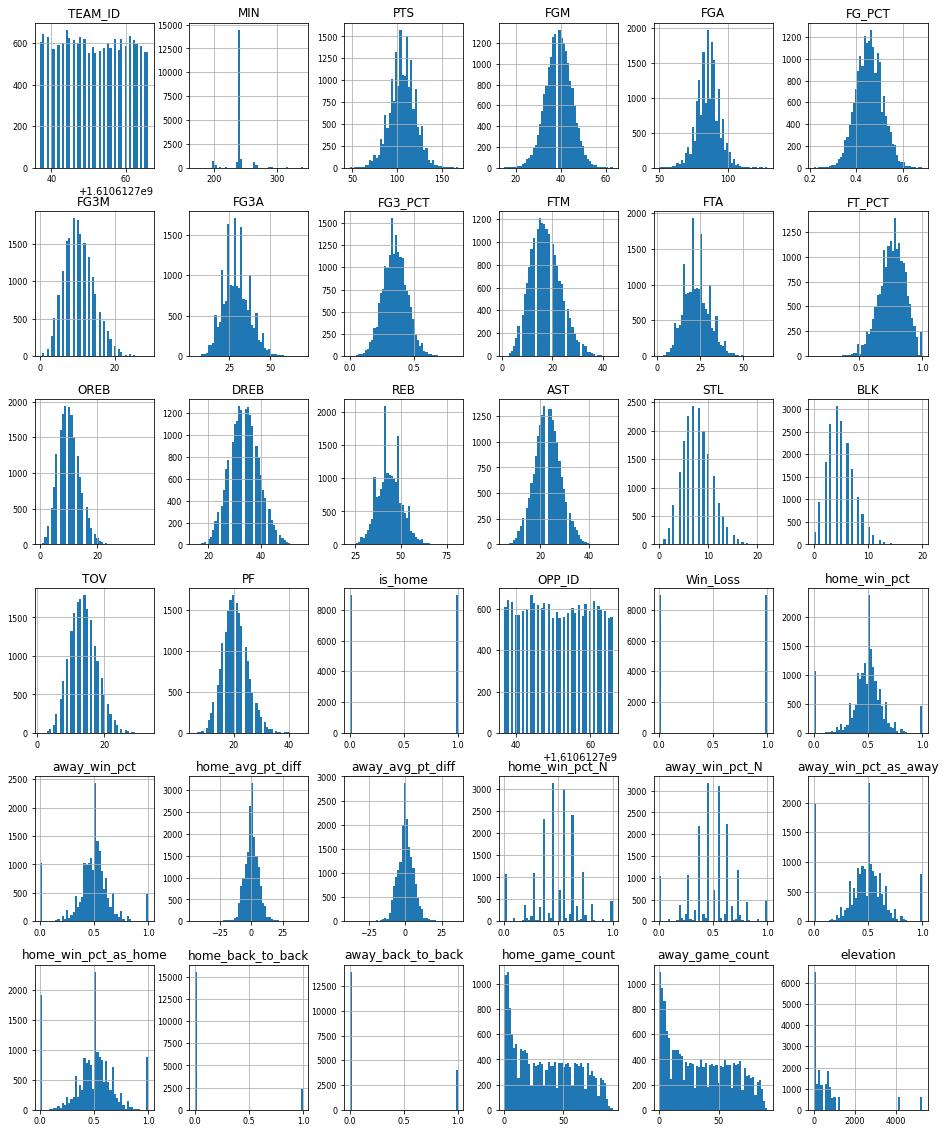

In [116]:
#plot numeric variables
list(set(temp_df.dtypes.tolist()))
df_num = temp_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## B. Correlation Matrix

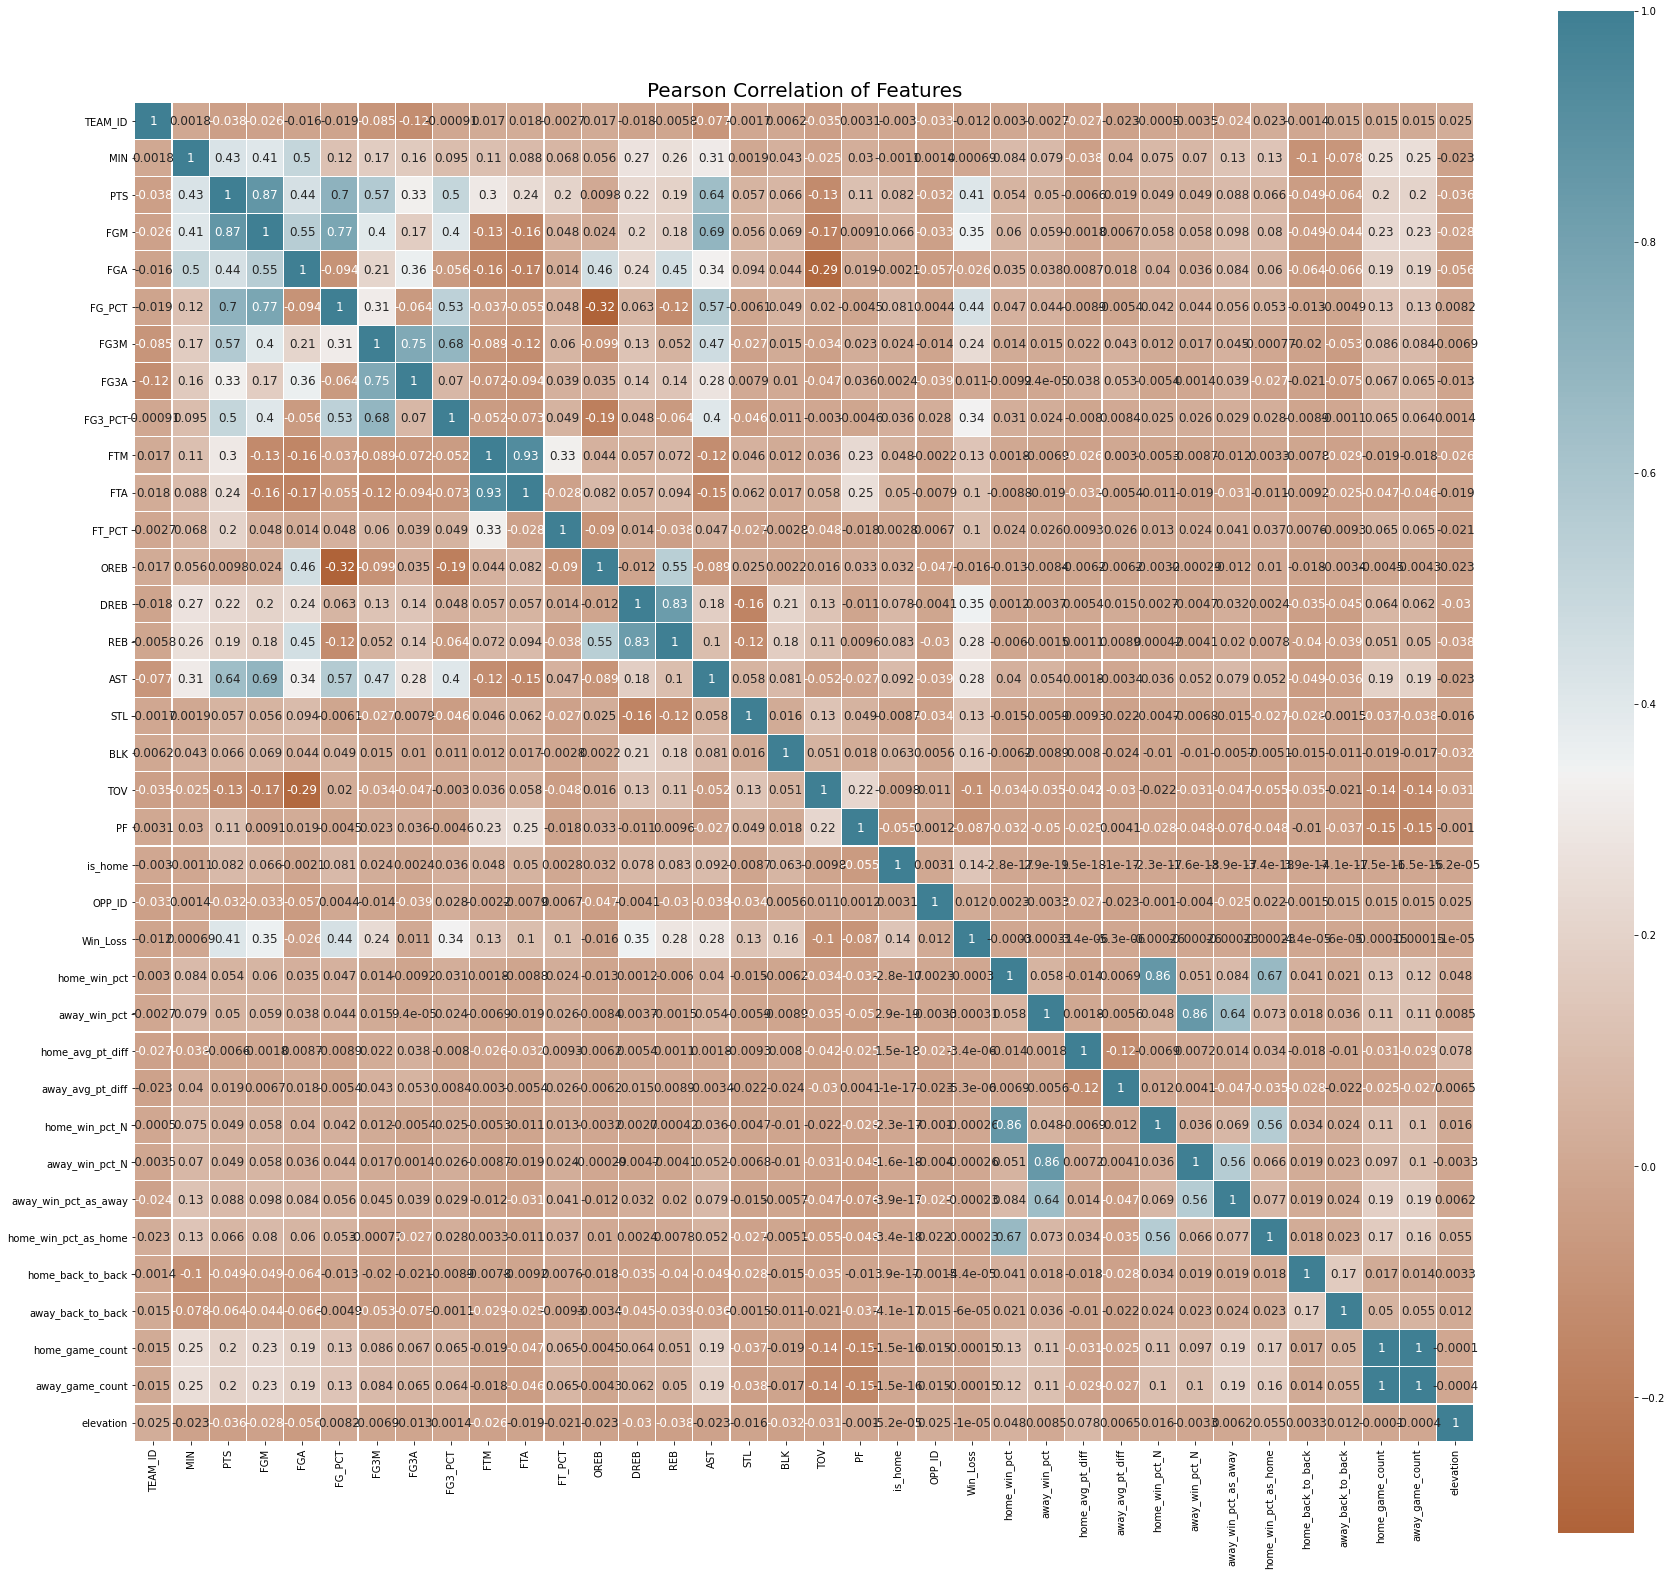

In [117]:
#correlation matrix

correlation_matrix = temp_df.select_dtypes(exclude=['category','object'])

plt.figure(figsize=(30,28))
plt.title('Pearson Correlation of Features', size = 20)
colormap = sns.diverging_palette(30, 220, as_cmap = True)
sns.heatmap(correlation_matrix.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

## C. Feature Importance

[0.01739962 0.         0.0229074  0.02458847 0.06773115 0.04224714
 0.02821148 0.09068545 0.02712268 0.02143029 0.0478322  0.02531619
 0.0215575  0.02155593 0.02056154 0.07315609 0.05439225 0.03280489
 0.03149262 0.02603235 0.02706768 0.02477458 0.01685591 0.
 0.01806958 0.01765619 0.02541944 0.02315576 0.0181397  0.01802511
 0.01798886 0.0180697  0.00941268 0.01128674 0.01902118 0.01909087
 0.01894077]


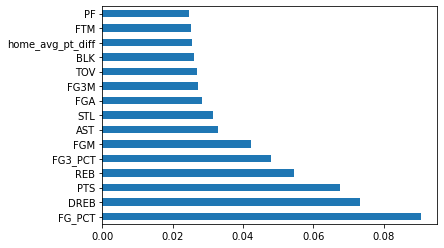

In [118]:
temp_df2 = temp_df.drop(columns=['TEAM_NAME','GAME_DATE'])


temp_df2["SEASON_ID"] = temp_df["SEASON_ID"].astype('category')
temp_df2["TEAM_ID"] = temp_df["TEAM_ID"].astype('category')

col_name="Win_Loss"
first_col = temp_df2.pop(col_name)
temp_df2.insert(0, col_name, first_col)


#Feature importance
import pandas as pd
import numpy as np


X = temp_df2.iloc[:,1:38]  #independent columns
y = temp_df2.iloc[:,0]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()


## D. Finalize Features - Drop multicolinear features

In [119]:
final_data = temp_df2[['Win_Loss','home_avg_pt_diff', 'FTM', 'PF', 'BLK', 'FG3M','TOV','FGA','STL','AST','FGM','FG3_PCT','REB','PTS','DREB','FG_PCT']]

# Split dataset in feature matrix and target matrix
## Perform standarizing of features and dataset split

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance). It is useful to standardize attributes for a model. Standardization of datasets is a common requirement. Also we split dataset for better generalisation

In [125]:
# We isolate the features matrix from the DataFrame.
features_matrix = final_data.iloc[:, 1:16]

# We isolate the target vector from the DataFrame.
target_vector = final_data.iloc[:, 0]


#########SVM##############



# Scale the data to be between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_matrix)
X = scaler.transform(features_matrix)

#Split dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 1st model - SVM

In this part I will experiment with different hyperparameters and kernels in order to find the best combination for prediction.

## Running SVM with Linear, RBF, Polynomial kernel

In [40]:
#SVM with Linear kernel

svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

print('Accuracy with of SVM with Linear kernel :',metrics.accuracy_score(y_test,y_pred))


#SVM with RBF kernel which is the default option

svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

print('Accuracy with of SVM with RBF kernel :',metrics.accuracy_score(y_test,y_pred))


#SVM Polynomial kernel

svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

print('Accuracy with of SVM with Polynomial kernel:',metrics.accuracy_score(y_test,y_pred))

Accuracy with of SVM with Linear kernel : 0.8370019504040123
Accuracy with of SVM with RBF kernel : 0.8333797715241015
Accuracy with of SVM with Polynomial kernel: 0.83365840066871


## Apply K fold cross validation with Linear, RBF, Polynomial kernel

In [41]:
# K fold cross validation with different kernels


#CV with Linear kernel

from sklearn.model_selection import cross_val_score
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print('Accuracy with 10 fold cross validation and linear kernel', scores.mean())


#CV with Rbf kernel


svc=SVC(kernel='rbf')
scores2 = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation

print('Accuracy with 10 fold cross validation and linear kernel', scores2.mean())


#CV with polynomial kernel


svc=SVC(kernel='poly')
scores3 = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation

print('Accuracy with 10 fold cross validation and linear kernel', scores3.mean())

Accuracy with 10 fold cross validation and linear kernel 0.8352668598205717
Accuracy with 10 fold cross validation and linear kernel 0.8317554957254607
Accuracy with 10 fold cross validation and linear kernel 0.8306407306310419


# Tune c parameter for Linear kernel


The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.

Thus for a very large values we can cause overfitting of the model and for a very small value of C we can cause underfitting.Thus the value of C must be chosen in such a manner that it generalised the unseen data well

[0.8352668598205717, 0.8353225701269785, 0.8356012148200594, 0.8353784046481151, 0.8353226943417085, 0.8353227253953909, 0.8352669840353018, 0.8353784046481152, 0.8353227253953909]


Text(0, 0.5, 'Cross-Validated Accuracy')

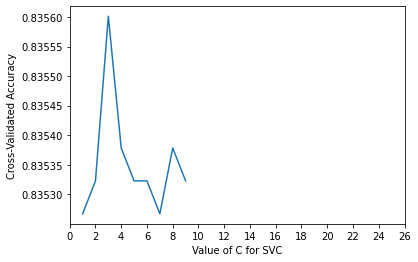

In [42]:
#Explore c value for linear kernel


C_range=list(range(1,10))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  



C_values=list(range(1,10))
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(C_values,acc_score)
plt.xticks(np.arange(0,27,2))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')




# Tune gamma parameter for RBF kernel

Technically, the gamma parameter is the inverse of the standard deviation of the RBF kernel (Gaussian function), which is used as similarity measure between two points. Intuitively, a small gamma value define a Gaussian function with a large variance. In this case, two points can be considered similar even if are far from each other. In the other hand, a large gamma value means define a Gaussian function with a small variance and in this case, two points are considered similar just if they are close to each other

[0.8107465305273227, 0.83231374777578, 0.8350437080581201, 0.8294707520891365, 0.7536806377184238, 0.5054070050896986, 0.49994432074727585]


Text(0, 0.5, 'Cross-Validated Accuracy')

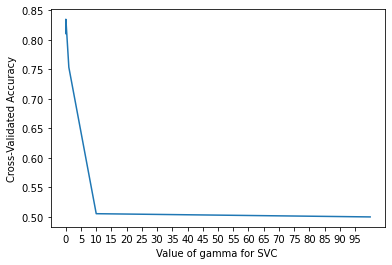

In [43]:
#rbf and different gamma


gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  

gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.xticks(np.arange(0.0001,100,5))
plt.ylabel('Cross-Validated Accuracy')


[0.8350437080581201, 0.8350993252034792, 0.8350437391118024, 0.8345980566605491, 0.8334833226198128]


Text(0, 0.5, 'Cross-Validated Accuracy')

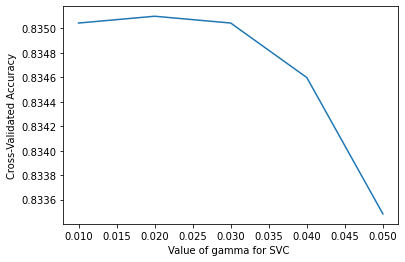

In [44]:
gamma_range=[0.01,0.02,0.03,0.04,0.05]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    




gamma_range=[0.01,0.02,0.03,0.04,0.05]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis) . Gamma = 0.02 is the best
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

# Polynomial kernel with different degree

[0.5662080348298104, 0.8306407306310419, 0.5909525096033513, 0.8130313983783767, 0.5726189433673993]


Text(0, 0.5, 'Cross-Validated Accuracy')

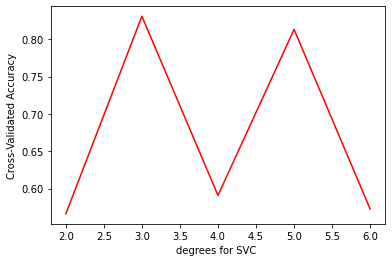

In [45]:
#polynomial kernel with different degree

degree=[2,3,4,5,6]
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  


degree=[2,3,4,5,6]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis). Degree = 3
plt.plot(degree,acc_score,color='r')
plt.xlabel('degrees for SVC ')                    
plt.ylabel('Cross-Validated Accuracy')

# For each combination of kernel and parameters we run one pure prediction and one with CV

# A. SVM with C = 2 and Linear kernel

In [46]:
#SVM with C=0.1 and linear kernel


svc= SVC(kernel='linear',C=2)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
accuracy_score= metrics.accuracy_score(y_test,y_predict)
print(accuracy_score)

#with crossvalidation
svc=SVC(kernel='linear',C=0.1)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

0.8367233212594037
[0.8189415  0.82896936 0.83119777 0.83286908 0.84782609 0.84503902
 0.8400223  0.83500557 0.83166109 0.8400223 ]
0.8351554081540759


# SVM with g = 0.02 and RBF kernel

In [47]:
from sklearn.svm import SVC
svc= SVC(kernel='rbf',gamma=0.02)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
print(accuracy_score)

#with cross validation
svc=SVC(kernel='linear',gamma=0.03)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())


0.8364446921147952
[0.82005571 0.82674095 0.83064067 0.83509749 0.84894091 0.84671126
 0.83835006 0.83444816 0.83221851 0.83946488]
0.8352668598205717


# SVM with degree = 3 and polynomial kernel

In [48]:
#3. SVM with poly of degree 3

from sklearn.svm import SVC
svc= SVC(kernel='poly',degree=3)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
accuracy_score= metrics.accuracy_score(y_test,y_predict)
print(accuracy_score)

# with cross validation
svc=SVC(kernel='poly',degree=3)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

0.83365840066871
[0.81169916 0.8367688  0.82451253 0.83231198 0.85005574 0.83500557
 0.83166109 0.8277592  0.82497213 0.83166109]
0.8306407306310419


# Grid search to find best parameter

In [126]:
svm_model= SVC()


tuned_parameters = {
 'C': (np.arange(0.1,5,0.5)) , 'kernel': ['linear'],
 'C': (np.arange(0.1,5,0.5)) , 'gamma': [0.01,0.02,0.03,0.04,0.05], 'kernel': ['rbf'],
 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05], 'C':(np.arange(0.1,1,0.1)) , 'kernel':['poly']
                   }

In [127]:
model_svm = GridSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy')

model_svm.fit(X_train, y_train)
print(model_svm.best_score_)

print(model_svm.best_params_)



0.8316955732629351
{'C': 0.9, 'degree': 3, 'gamma': 0.05, 'kernel': 'poly'}


In [128]:
y_pred= model_svm.predict(X_test)
print(metrics.accuracy_score(y_pred,y_test))


0.8286430760657565


## Confusion matrix

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83      1828
         1.0       0.84      0.81      0.82      1761

    accuracy                           0.83      3589
   macro avg       0.83      0.83      0.83      3589
weighted avg       0.83      0.83      0.83      3589



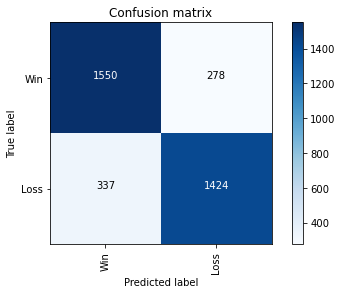

In [141]:
# For the best model run confusion matrix and classification report


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)



#Get the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# plot the confusion matrix
plot_confusion_matrix(confusion_matrix,  classes = ['Win','Loss'])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## ROC curve

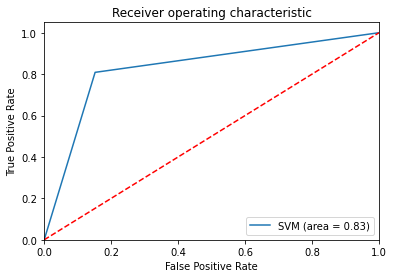

In [142]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
svm_roc_auc = roc_auc_score(y_test, model_svm.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_svm.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# 2nd model - Decision Tree

In [143]:
#Split dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [150]:
#hyper parameter tuning

dt = DecisionTreeClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")


grid_search.fit(X_train, y_train)

score_df = pd.DataFrame(grid_search.cv_results_)
print(grid_search.best_params_)
score_df.head()

score_df.nlargest(5,"mean_test_score")

grid_search.best_estimator_

dt_best = grid_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20}


In [146]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(metrics.confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, dt_classifier.predict(X_test)))
    
    
    
evaluate_model(dt_best)

Train Accuracy : 0.8212469522814351
Train Confusion Matrix:
[[5906 1237]
 [1329 5883]]
--------------------------------------------------
Test Accuracy : 0.75424909445528
Test Confusion Matrix:
[[1374  454]
 [ 428 1333]]


## Confusion matrix

              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76      1828
         1.0       0.75      0.76      0.75      1761

    accuracy                           0.75      3589
   macro avg       0.75      0.75      0.75      3589
weighted avg       0.75      0.75      0.75      3589



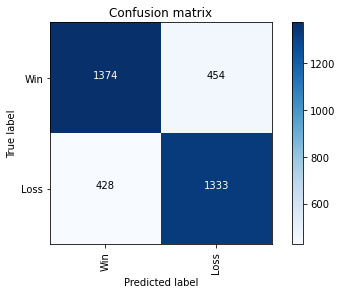

In [148]:
# For the best model run confusion matrix and classification report


confusion_matrix = metrics.confusion_matrix(y_test, dt_best.predict(X_test))



#Get the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# plot the confusion matrix
plot_confusion_matrix(confusion_matrix,  classes = ['Win','Loss'])

from sklearn.metrics import classification_report
print(classification_report(y_test, dt_best.predict(X_test)))

# ROC Curve

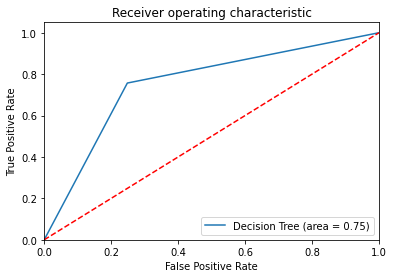

In [149]:
#ROC Curve


logit_roc_auc = roc_auc_score(y_test, dt_best.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt_best.predict(X_test))



plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# 3rd model - Random Forest

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_rf))


# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())




0.8002229033156868
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [157]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 11)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 100, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state=42)
# Random search of parameters, using 2-fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, n_jobs = -1)
# Fit the random search model
rfc_random.fit(X_train, y_train)
y_pred_rfr_random = rfc_random.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_rfr_random))

{'bootstrap': [True, False],
 'max_depth': [0, 20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 2 folds for each of 100 candidates, totalling 200 fits
0.8063527444970744


In [158]:
print(rfc_random.best_params_)

{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      1828
         1.0       0.80      0.80      0.80      1761

    accuracy                           0.81      3589
   macro avg       0.81      0.81      0.81      3589
weighted avg       0.81      0.81      0.81      3589



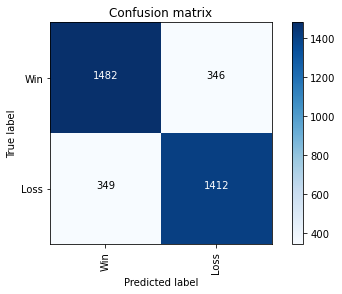

In [159]:
# For the best model run confusion matrix and classification report


confusion_matrix = metrics.confusion_matrix(y_test, rfc_random.predict(X_test))



#Get the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# plot the confusion matrix
plot_confusion_matrix(confusion_matrix,  classes = ['Win','Loss'])

from sklearn.metrics import classification_report
print(classification_report(y_test, rfc_random.predict(X_test)))

# ROC Curve

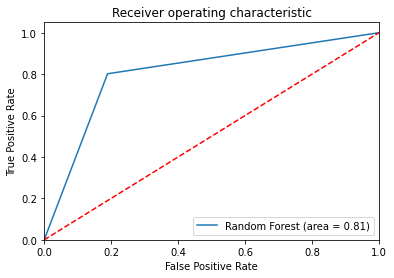

In [160]:
#ROC Curve


logit_roc_auc = roc_auc_score(y_test, rfc_random.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc_random.predict(X_test))



plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Results

The analysis shows that SVM performs the best with 83%. Very close is Random forest model with 81% and finally Decision trees with 75% accuracy

# Future work

It would be interesting to add player characteristics in the analysis as well as try out NN or CNN models